In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

#best alignment is at frame: 3998 or 1667

This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [3]:
pdb='/Users/NLoui/Desktop/NG_CHEM101.6_S24/Exercise4/2F4K.protein.pdb'
trajectory='/Users/NLoui/Desktop/NG_CHEM101.6_S24/Exercise4/2F4K.protein.s10.dcd'
xray_CA_pdb='/Users/NLoui/Desktop/NG_CHEM101.6_S24/Exercise4/2f4K.xray.CA.pdb'
outdir='/Users/NLoui/Desktop/NG_CHEM101.6_S24/Exercise4/outdir'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjectory:",trajectory)



outdir: /Users/NLoui/Desktop/NG_CHEM101.6_S24/Exercise4/outdir
pdb: /Users/NLoui/Desktop/NG_CHEM101.6_S24/Exercise4/2F4K.protein.pdb
trjectory: /Users/NLoui/Desktop/NG_CHEM101.6_S24/Exercise4/2F4K.protein.s10.dcd


In [4]:
stride_sel=10
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [5]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 6280

Starting frame: 0

Last frame: 6280

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA

In [6]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [7]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [8]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


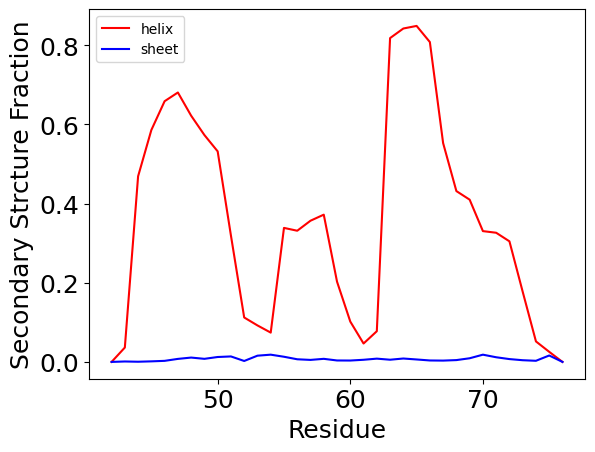

In [9]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [10]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [11]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [12]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




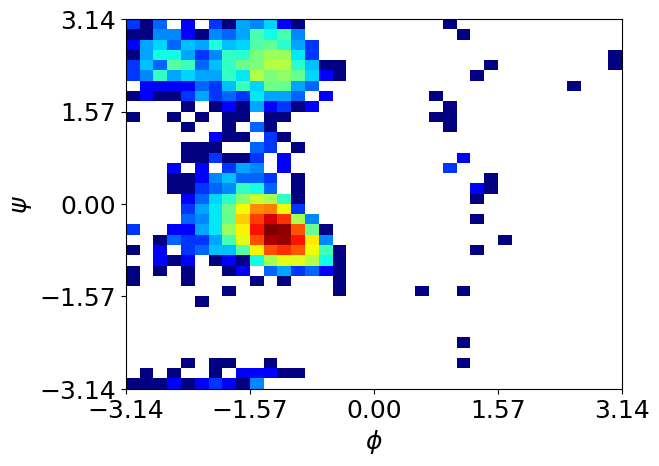

In [13]:
plot_phipsi(45)


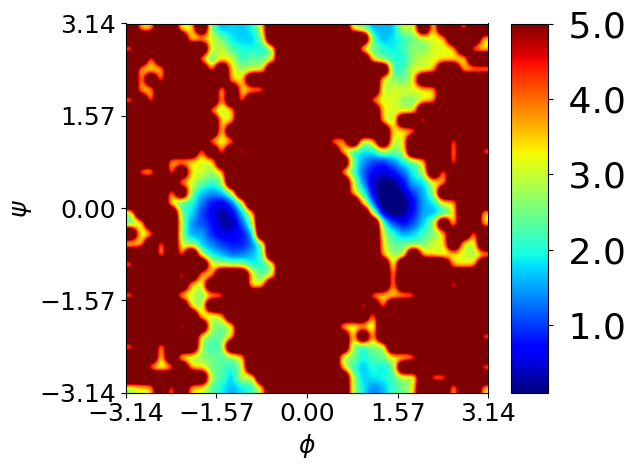

In [14]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(52)

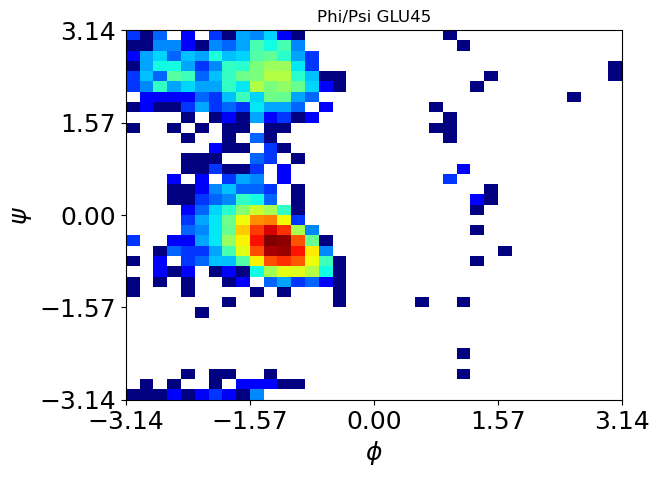

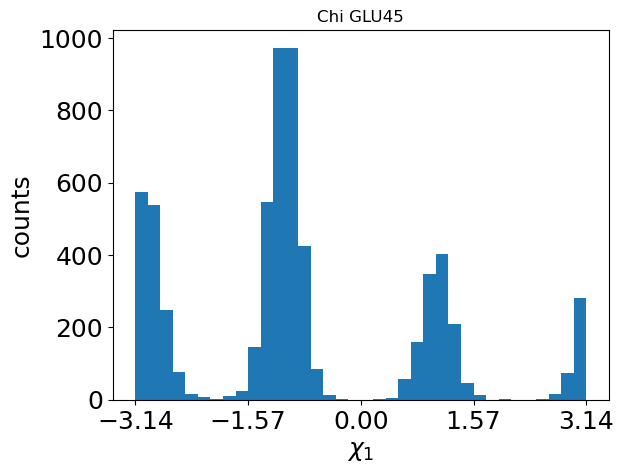

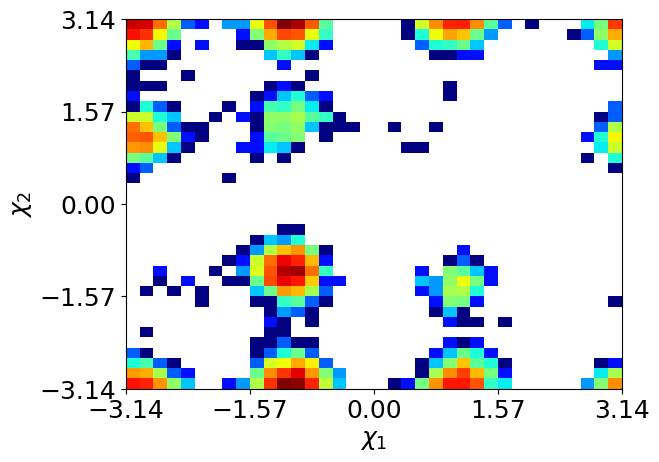

In [15]:
plt.title("Phi/Psi GLU45")
plot_phipsi(45)
plt.clf()

plt.title("Chi GLU45")
plot_chi(45)


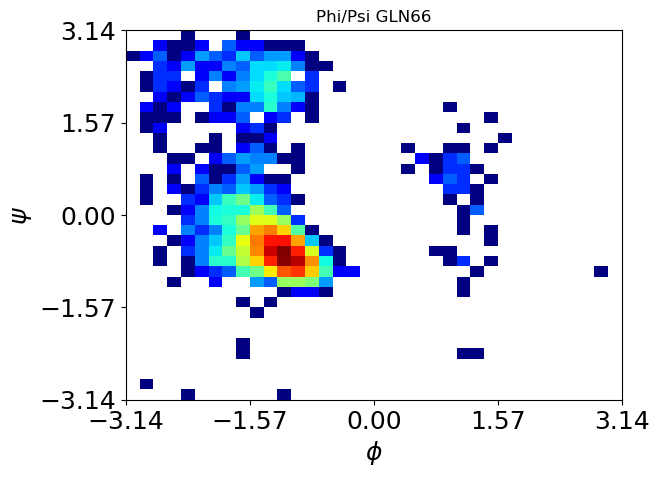

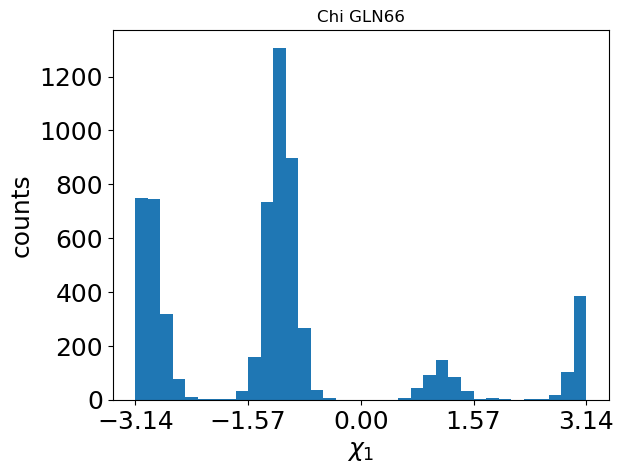

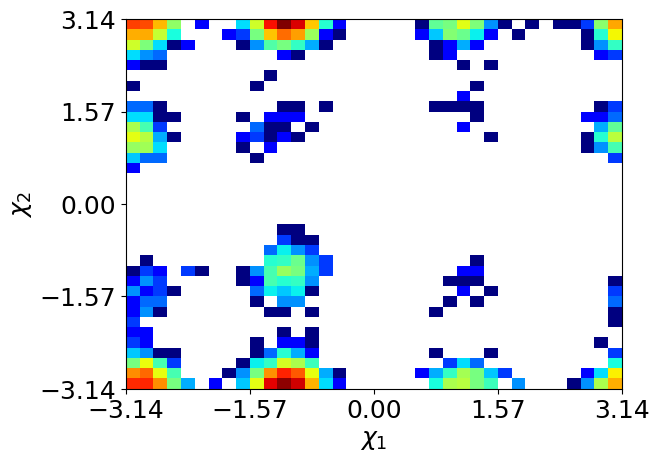

In [16]:
plt.title("Phi/Psi GLN66")
plot_phipsi(66)
plt.clf()
plt.title("Chi GLN66")
plot_chi(66)

In [17]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [18]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 6280 frames, 35 atoms, 35 residues, and unitcells at 0x151082b90>

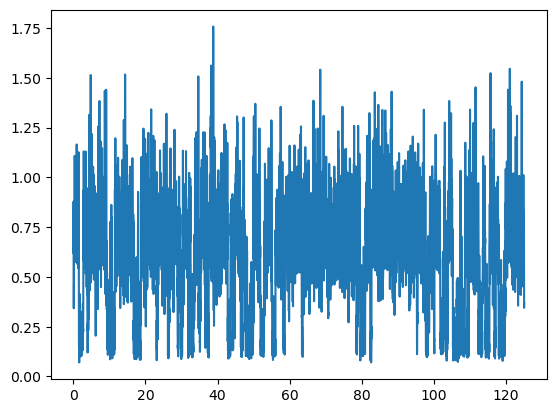

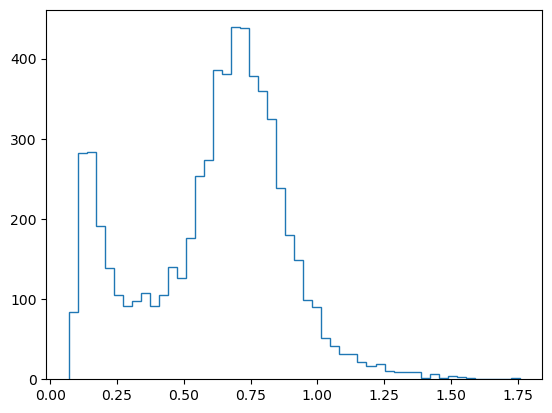

In [19]:
#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")



rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

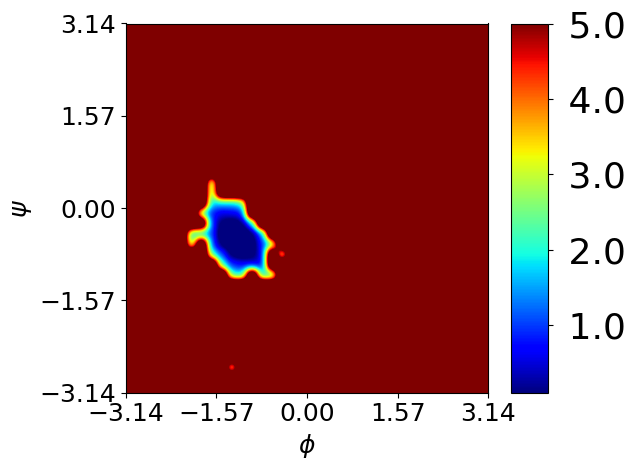

In [20]:
def plot_phipsi_FES_frames(res,frames):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res][frames],dihedral_dict['phi'][res][frames],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return


native_frames=np.where(rmsd<0.25)[0]
len(native_frames)
trj[native_frames].save_dcd(outdir+'native.dcd')

plot_phipsi_FES_frames(45,native_frames)


In [21]:
# Better version of phipsi_frames

def plot_phipsi_frames(res,frames):
 plt.hist2d(dihedral_dict['phi'][res][frames],dihedral_dict['psi'][res][frames],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi_frames(res,frames):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res][frames],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res][frames],dihedral_dict['chi2'][res][frames],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return

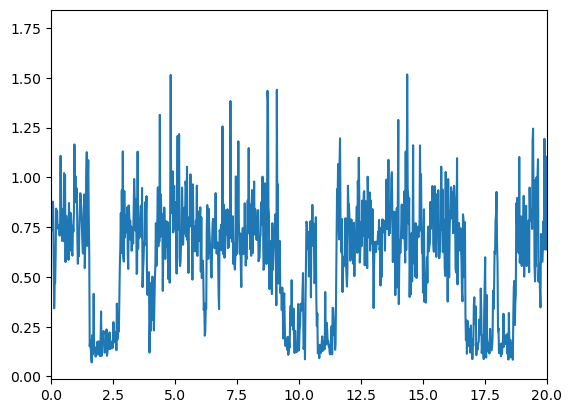

(array([ 84., 282., 283., 191., 139., 105.,  92.,  98., 108.,  92., 105.,
        140., 126., 176., 254., 274., 386., 381., 439., 438., 378., 359.,
        324., 238., 180., 149.,  99.,  90.,  52.,  42.,  32.,  32.,  22.,
         17.,  19.,  10.,   9.,   9.,   9.,   1.,   6.,   1.,   4.,   3.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.070214  , 0.10396545, 0.13771689, 0.17146833, 0.20521978,
        0.23897122, 0.27272266, 0.30647409, 0.34022555, 0.37397701,
        0.40772843, 0.44147986, 0.47523132, 0.50898278, 0.54273421,
        0.57648563, 0.61023712, 0.64398855, 0.67773998, 0.71149141,
        0.74524283, 0.77899432, 0.81274575, 0.84649718, 0.88024867,
        0.91400009, 0.94775152, 0.98150295, 1.01525438, 1.04900587,
        1.08275723, 1.11650872, 1.15026021, 1.18401158, 1.21776307,
        1.25151455, 1.28526592, 1.31901741, 1.3527689 , 1.38652027,
        1.42027175, 1.45402312, 1.48777461, 1.5215261 , 1.55527747,
        1.58902895, 1.62278032, 1.65653181, 1.

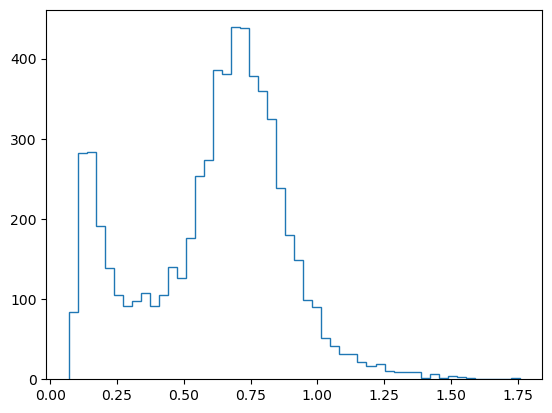

In [22]:
# Using better version

native_frames=np.where(rmsd<0.25)[0]
unfolded_frames=np.where(rmsd>0.60)[0]

trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

# CA_trj_sel=trj.topology.select("name CA")
# CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.xlim(0,20)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)

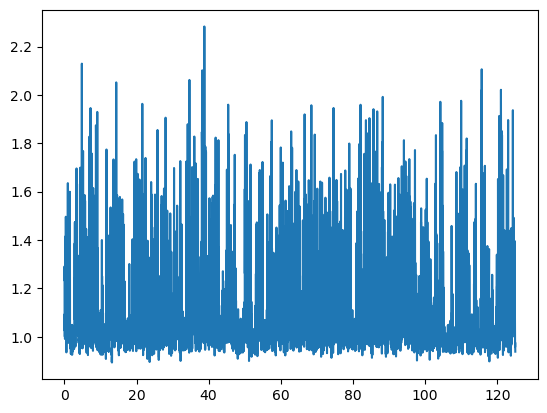

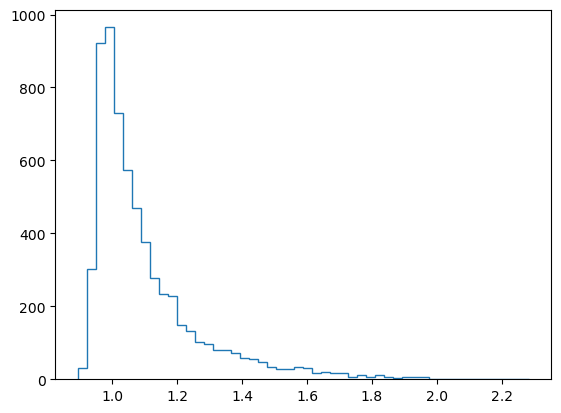

In [23]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [24]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(6280, 2)


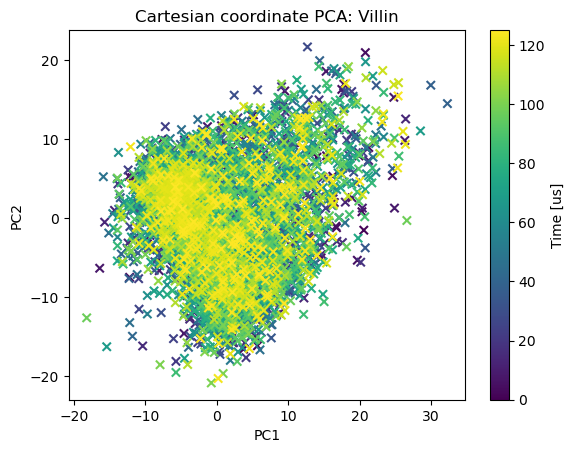

In [25]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

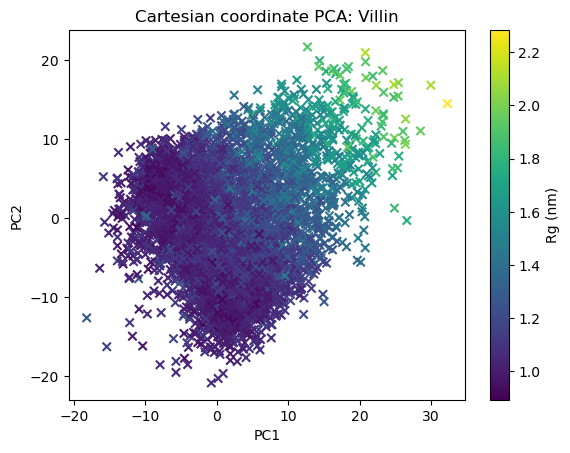

In [26]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')

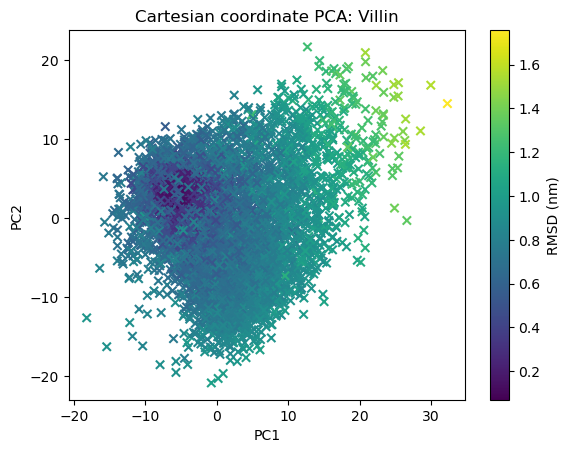

In [27]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

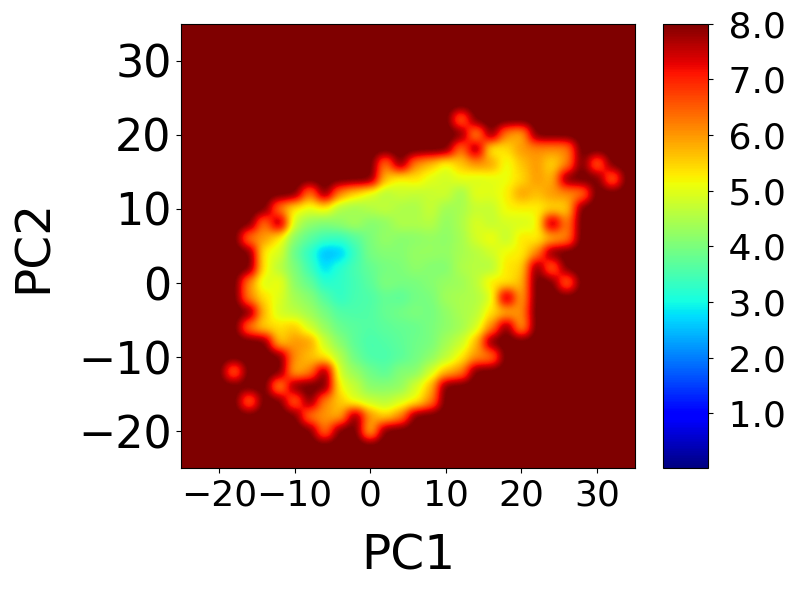

In [28]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [29]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters



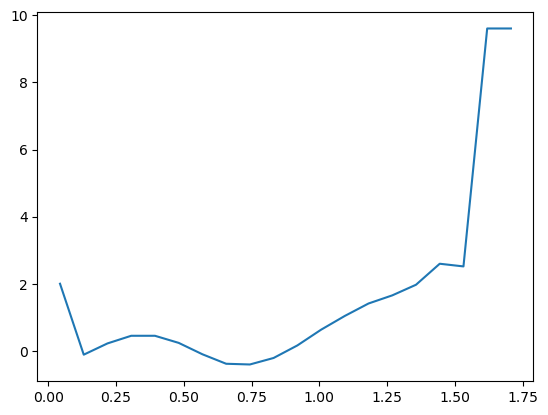

In [30]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.plot(xedges,dG_RMSD)

In [31]:
#Possible Homework Prompt:
#Visualize the lowest free energy basin
basin_frames=np.where((rmsd>0.60) & (rmsd<0.80))[0]
len(basin_frames)
trj[basin_frames].save_dcd(outdir+'rmsd.dgmin.basin.dcd')

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

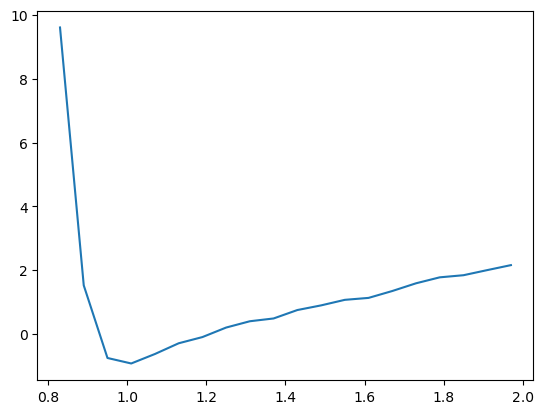

In [32]:
dG_rg,xedges=free_energy1D(rg,300,0.8,2.0,20)

plt.plot(xedges,dG_rg)

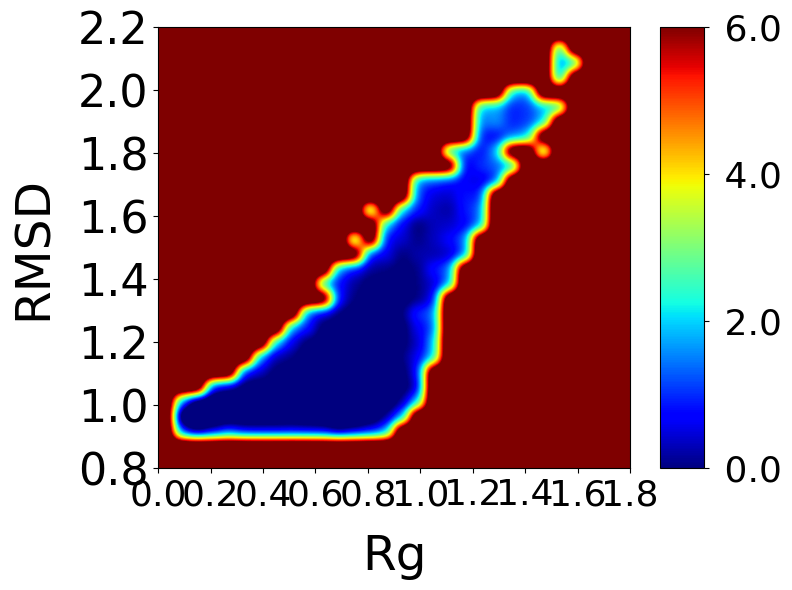

In [33]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.2, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.tight_layout()

In [34]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [35]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

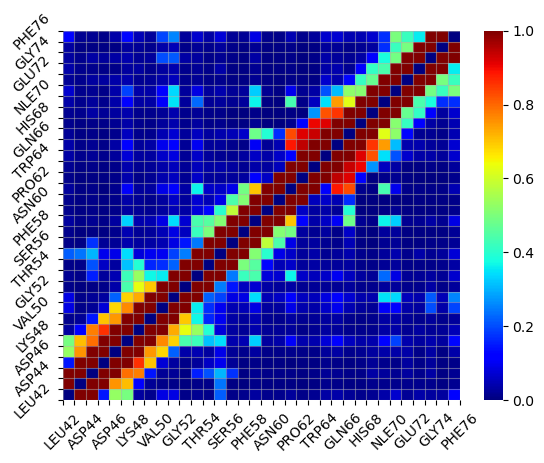

In [36]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

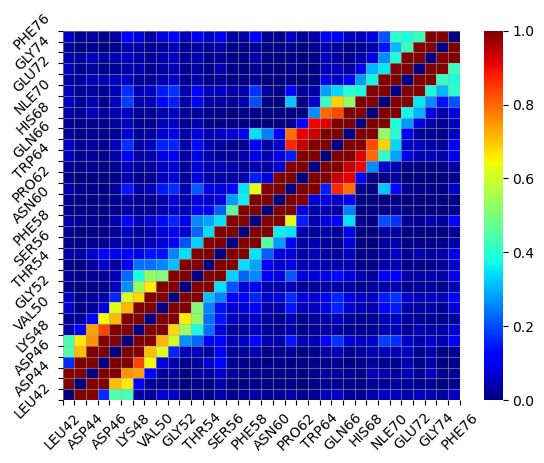

In [37]:
#Lets Make a Contact Map of the low dG Basin 
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[basin_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

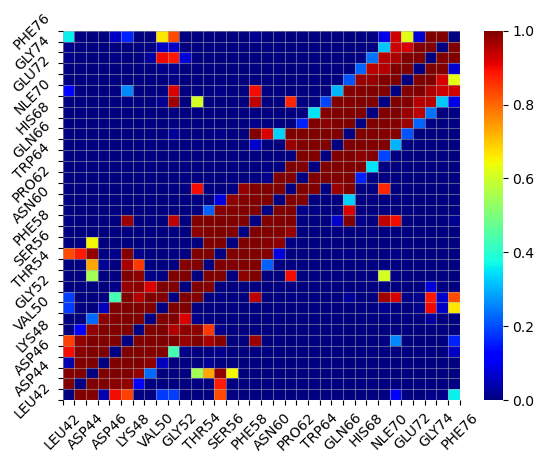

In [38]:
#Lets Make a Contact Map of the native frames
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[native_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [39]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [40]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [41]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

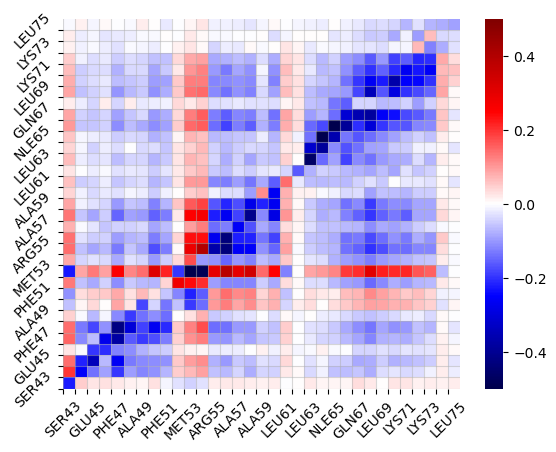

In [42]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

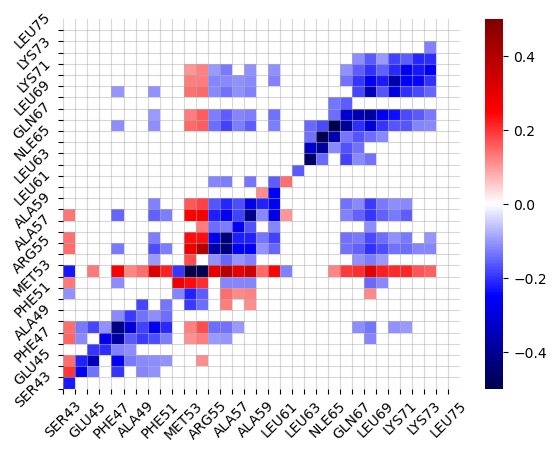

In [43]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

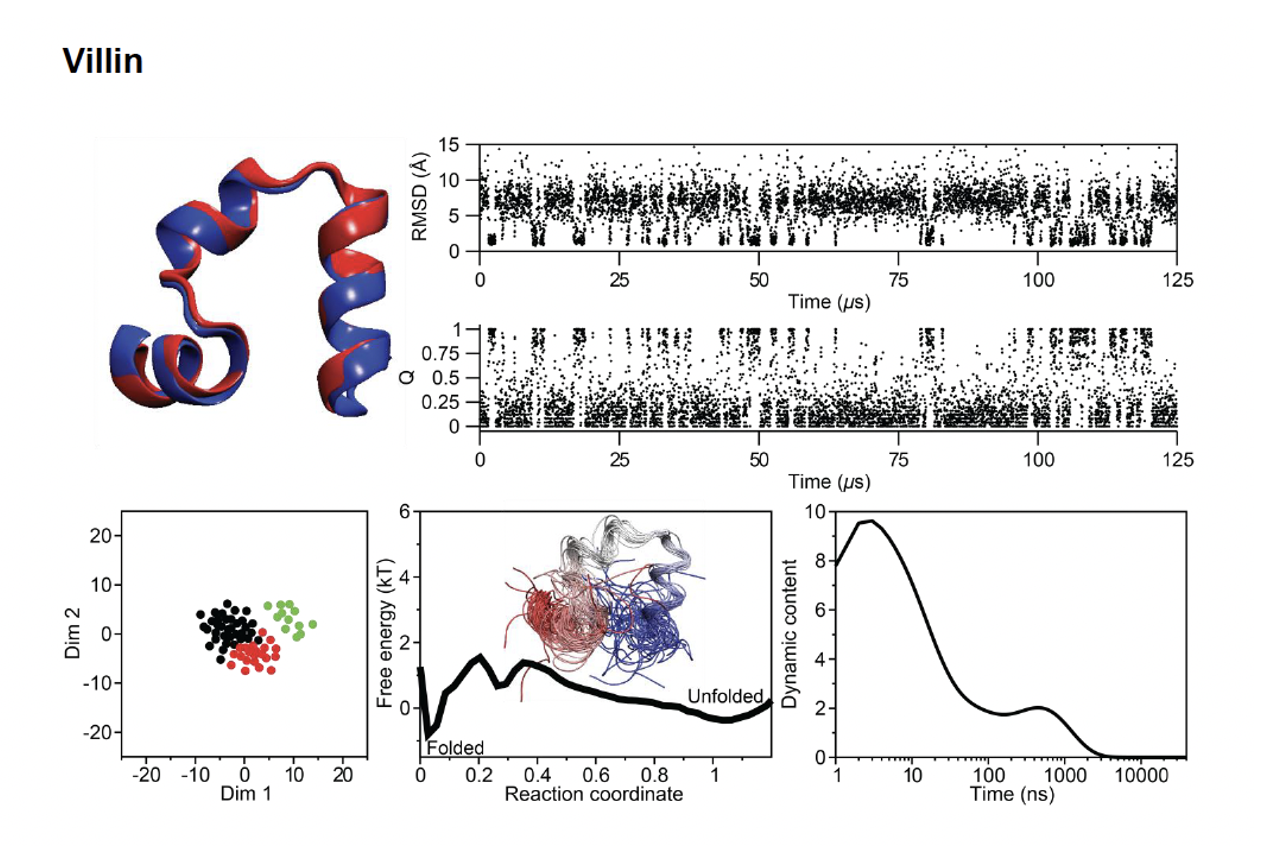

First we need to determine the native contacts and calculate Q

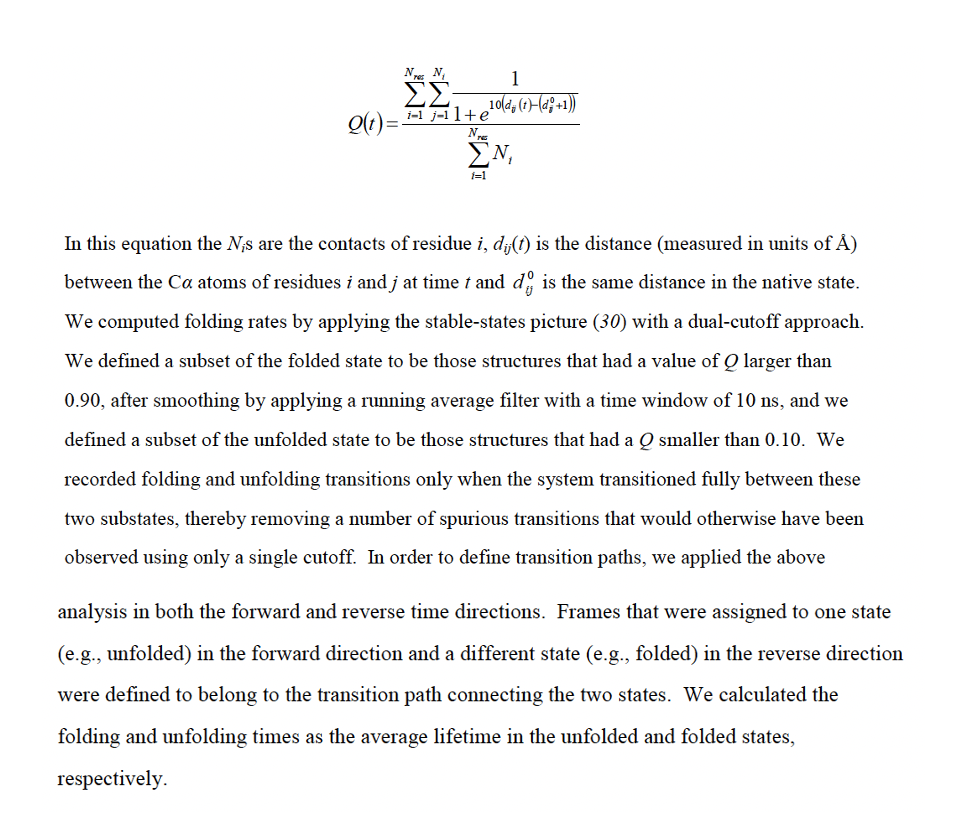

In [44]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x150f462d0>

In [45]:
# Lets Make a 1D array that contains all native distances pairs:
native_distance_matrix1D=[]
# make a 1D Array that only contains distances 
# between residue pairs seperated by more than 7 residues

for i in range(0,34):
     for j in range(0, 34):
        if(abs(i-j)>7):
           #print(i,j)
            dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
            native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10
np.shape(native_distance_matrix1D)


In [46]:
Native_Contacts=np.where(native_distance_matrix1D<10)
Native_Contact_Distances=native_distance_matrix1D[Native_Contacts]
np.shape(Native_Contact_Distances)

(148,)

In [ ]:
# Do the same thing for our trajectory, 
# making an array that is contacts vs. #frames in the trajectory

traj_CA_distance_matrix1D=[]
for i in range(0,34):
    for j in range(0, 34):
        if(abs(i-j)>7):
            dist=md.compute_distances(trjCA,[[i,j]])[:,0]
            traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10

np.shape(traj_CA_distance_matrix1D)

#Traj_Native_Contact_Distances=traj_CA_distance_matrix1D[Native_Contacts]


In [53]:
np.shape(traj_CA_distance_matrix1D[:,native_frames])
#Distances For All CA-CA pairs in the native frames
traj_CA_distance_matrix1D[:,native_frames]
native_average=np.average(traj_CA_distance_matrix1D[:,native_frames],axis=1)
np.shape(native_average)

(702,)

In [54]:
Native_Contact_Indices=np.where(native_average<10.0)[0]
len(Native_Contact_Indices)

Native_Contacts_Trj_Dist=traj_CA_distance_matrix1D[Native_Contact_Indices]
np.shape(Native_Contacts_Trj_Dist)

Native_Contacts_Xray_Dist=native_distance_matrix1D[Native_Contact_Indices]

In [55]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Xray_Distance_Expand=np.zeros(np.shape(Native_Contacts_Trj_Dist))
for i in range(0,len(Native_Contacts_Trj_Dist)):
    Xray_Distance_Expand[i,:]=Native_Contacts_Xray_Dist[i]
    
Xray_Distance_Expand

array([[ 9.98572636,  9.98572636,  9.98572636, ...,  9.98572636,
         9.98572636,  9.98572636],
       [10.45245934, 10.45245934, 10.45245934, ..., 10.45245934,
        10.45245934, 10.45245934],
       [ 9.7042532 ,  9.7042532 ,  9.7042532 , ...,  9.7042532 ,
         9.7042532 ,  9.7042532 ],
       ...,
       [ 7.31312943,  7.31312943,  7.31312943, ...,  7.31312943,
         7.31312943,  7.31312943],
       [ 7.79883337,  7.79883337,  7.79883337, ...,  7.79883337,
         7.79883337,  7.79883337],
       [ 9.57147789,  9.57147789,  9.57147789, ...,  9.57147789,
         9.57147789,  9.57147789]])

In [56]:
for i in range(0,len(Native_Contacts_Trj_Dist)):
    print(Native_Contacts_Xray_Dist[i],Native_Contacts_Trj_Dist[i])

9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
10.452459 [ 9.374432 18.456451 13.714305 ... 11.399559  9.84092   8.788097]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
10.225195 [14.985344 16.675589 15.238585 ...  8.309675  8.071144  8.658443]
6.8318415 [12.484558  14.192814  12.563656  ...  5.9191756  5.

In [48]:
#Select Only the Frames with low RMSD from native state
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
np.shape(trj_native_distances)

(702, 1016)

In [49]:
np.shape(Traj_Native_Contact_Distances)

(148, 6280)

In [50]:
for i in range(0,len(Native_Contact_Distances)):
  print(Native_Contact_Distances[i],Traj_Native_Contact_Distances[i])

9.288557 [16.155031 10.791452 12.989177 ...  9.819974 13.44309  12.631355]
9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.792495 [17.497013 20.938164 14.502391 ...  9.647299 10.491154 12.31331 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
7.2052145 [18.622604 19.704548 15.620064 ... 10.816223 11.794368

In [57]:
np.shape(Native_Contacts_Xray_Dist)


(44,)

In [58]:
#Write a function to Calculate Q 
def qCalc(dist,nativedist):
    num=np.sum(1/(1+np.exp(10*np.subtract(dist,nativedist+1))))
    denom=46
    q_in=num/denom
    return q_in

In [73]:
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distances=traj_CA_distance_matrix1D[Native_Contacts]

#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_Native_Contact_Distances))
for i in range(0,len(Native_Contact_Distances)):
    Native_Contact_Distances_nframes[i]=Native_Contact_Distances[i]

In [74]:
for i in range(0,46):
    print(Native_Contacts_Xray_Dist[i],Native_Contacts_Trj_Dist[i])

9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
10.452459 [ 9.374432 18.456451 13.714305 ... 11.399559  9.84092   8.788097]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
10.225195 [14.985344 16.675589 15.238585 ...  8.309675  8.071144  8.658443]
6.8318415 [12.484558  14.192814  12.563656  ...  5.9191756  5.

IndexError: index 44 is out of bounds for axis 0 with size 44

In [75]:
# Check the shapes of the arrays
print("Shape of Native_Contacts_Xray_Dist:", Native_Contacts_Xray_Dist.shape)
print("Shape of Native_Contacts_Trj_Dist:", Native_Contacts_Trj_Dist.shape)

# Assuming Native_Contacts_Xray_Dist and Native_Contacts_Trj_Dist are 2D arrays
num_elements_xray = Native_Contacts_Xray_Dist.shape[0]
num_elements_trj = Native_Contacts_Trj_Dist.shape[0]

# Use the minimum size of both arrays to avoid IndexError
min_size = min(num_elements_xray, num_elements_trj)

# Adjust the loop range to be within the size of the smallest array
for i in range(min_size):  # Ensure the range is within bounds
    print(Native_Contacts_Xray_Dist[i], Native_Contacts_Trj_Dist[i])

Shape of Native_Contacts_Xray_Dist: (44,)
Shape of Native_Contacts_Trj_Dist: (44, 6280)
9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
10.452459 [ 9.374432 18.456451 13.714305 ... 11.399559  9.84092   8.788097]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
10.225195 [14.985344 16.675589 15.238585 ...  8.30

In [76]:
Xray_Distance_Expand=np.zeros(np.shape(Native_Contacts_Trj_Dist))
for i in range(0,len(Native_Contacts_Trj_Dist)):
    Xray_Distance_Expand[i,:]=Native_Contacts_Xray_Dist[i]
    
Xray_Distance_Expand

array([[ 9.98572636,  9.98572636,  9.98572636, ...,  9.98572636,
         9.98572636,  9.98572636],
       [10.45245934, 10.45245934, 10.45245934, ..., 10.45245934,
        10.45245934, 10.45245934],
       [ 9.7042532 ,  9.7042532 ,  9.7042532 , ...,  9.7042532 ,
         9.7042532 ,  9.7042532 ],
       ...,
       [ 7.31312943,  7.31312943,  7.31312943, ...,  7.31312943,
         7.31312943,  7.31312943],
       [ 7.79883337,  7.79883337,  7.79883337, ...,  7.79883337,
         7.79883337,  7.79883337],
       [ 9.57147789,  9.57147789,  9.57147789, ...,  9.57147789,
         9.57147789,  9.57147789]])

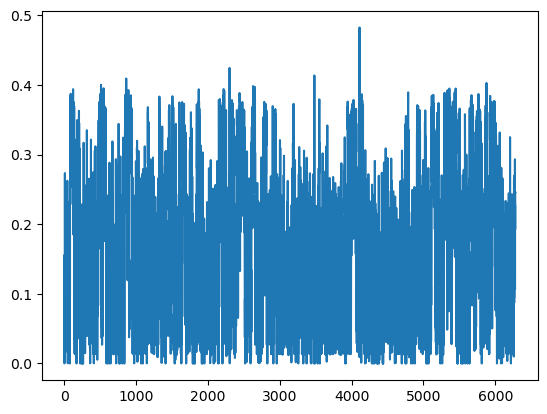

(array([1.087e+03, 1.503e+03, 9.610e+02, 6.850e+02, 4.700e+02, 4.940e+02,
        5.690e+02, 4.810e+02, 2.900e+01, 1.000e+00]),
 array([1.28075769e-25, 4.82478970e-02, 9.64957939e-02, 1.44743691e-01,
        1.92991588e-01, 2.41239485e-01, 2.89487382e-01, 3.37735279e-01,
        3.85983176e-01, 4.34231073e-01, 4.82478970e-01]),
 [<matplotlib.patches.Polygon at 0x152773990>])

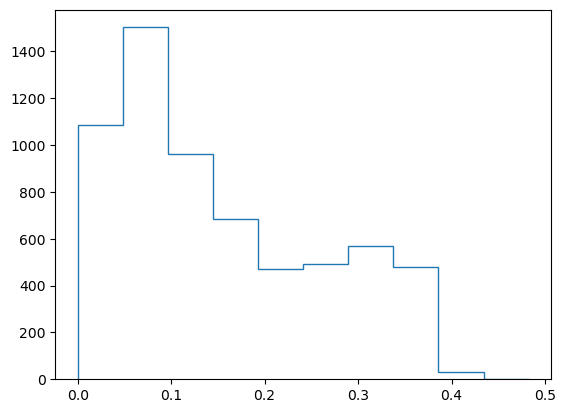

In [77]:
Q=1/(1+np.exp(10*(Traj_Native_Contact_Distances-(Native_Contact_Distances_nframes+1))))

Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_Contact_Distances)
plt.plot(Q)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')

In [78]:
#Now Lets Consider a "Native Portion of the Trajectory"
native_frames

array([  79,   80,   81, ..., 6007, 6009, 6011])

In [79]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [80]:
np.shape(native_distance_matrix1D)

(702,)

In [81]:
np.shape(traj_CA_distance_matrix1D)

(702, 6280)

In [82]:
#Select Only the Frames with low RMSD from native state
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
np.shape(trj_native_distances)

(702, 1016)

In [83]:
averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]
Native_Contacts

array([  5,  29,  30,  52,  53,  54,  55,  75,  76,  77,  98,  99, 120,
       123, 193, 196, 198, 211, 212, 215, 239, 240, 257, 258, 259, 260,
       275, 276, 277, 278, 279, 280, 296, 337, 341, 344, 500, 550, 557,
       569, 570, 635, 636, 684])

In [84]:
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distances=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distances))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)

(44, 6280)

In [85]:
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distances[i])

9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
10.452459 [ 9.374432 18.456451 13.714305 ... 11.399559  9.84092   8.788097]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
10.225195 [14.985344 16.675589 15.238585 ...  8.309675  8.071144  8.658443]
6.8318415 [12.484558  14.192814  12.563656  ...  5.9191756  5.

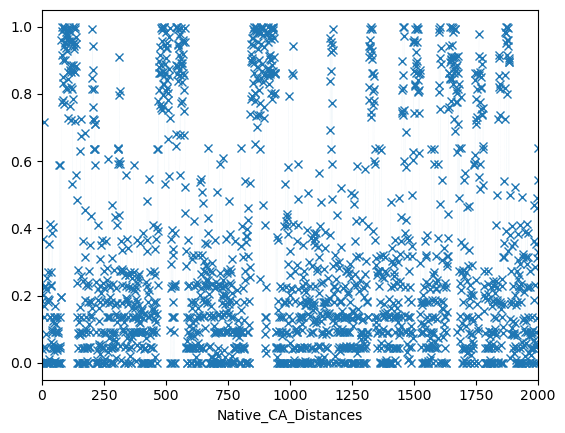

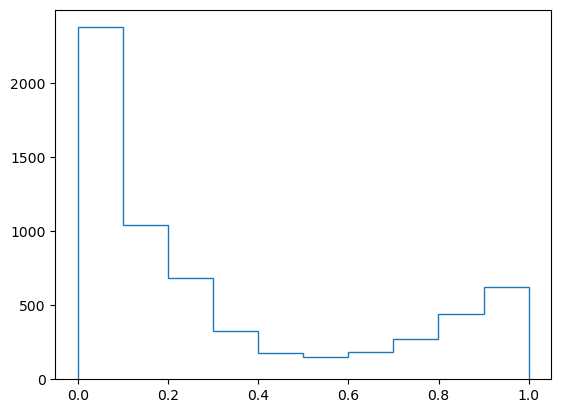

In [86]:
Q=1/(1+np.exp(10*(Traj_CA_Distances-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.xlabel("Native_CA_Distances")
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

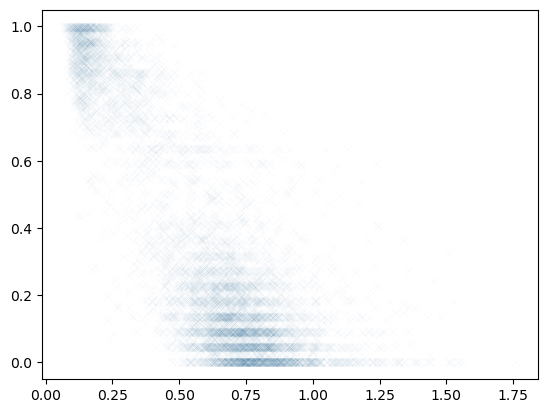

In [87]:
#Plot Q and a Histogram
plt.scatter(rmsd,Q,marker='x',linewidth=.01)

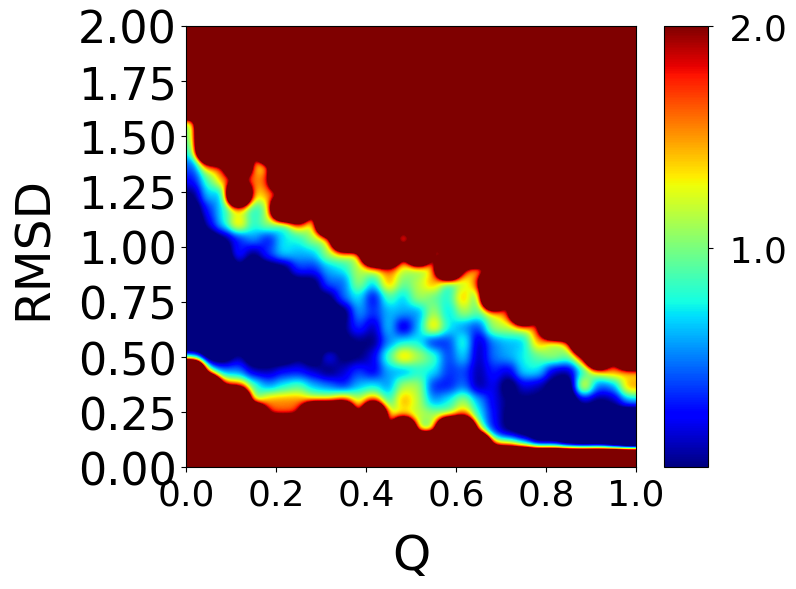

In [88]:
dG,xedges,yedges=free_energy(rmsd, Q, 300, 0, 2.0, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=2.0)
plt.yticks(size='26')
plt.tight_layout()

Text(0, 0.5, '$\\Delta$G')

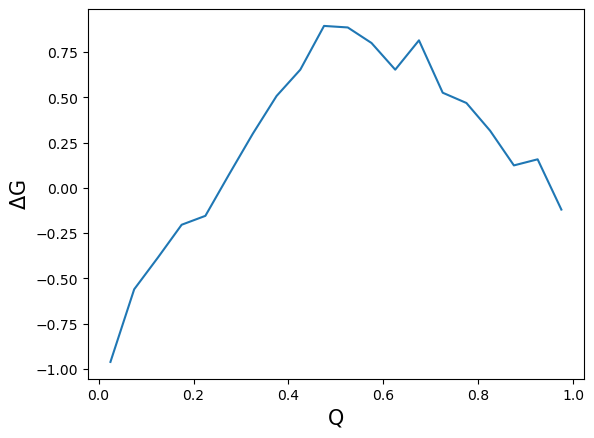

In [89]:
dG_Q,xedges=free_energy1D(Q,300,0,1,20)

plt.plot(xedges,dG_Q)
plt.xlabel("Q",size=15)
plt.ylabel("$\Delta$G",size=15)

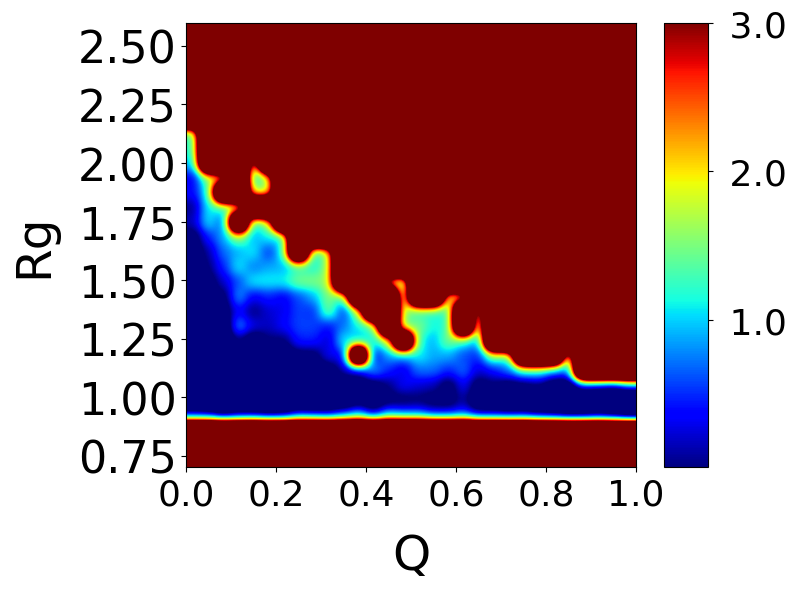

In [90]:
dG,xedges,yedges=free_energy(rg, Q, 300, 0.7, 2.6, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2,3]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()

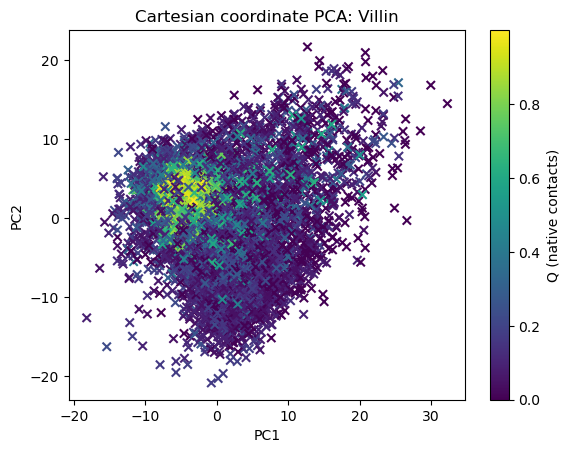

In [91]:
### plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=Q)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Q (native contacts)')

# End of provided code!!!

HW #4

In [93]:
#Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q
native_frames

array([  79,   80,   81, ..., 6007, 6009, 6011])

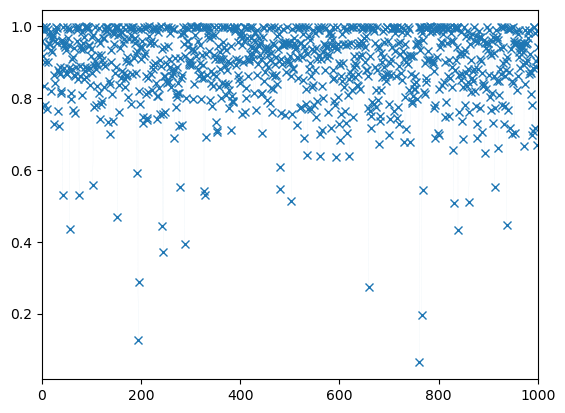

<function matplotlib.pyplot.show(close=None, block=None)>

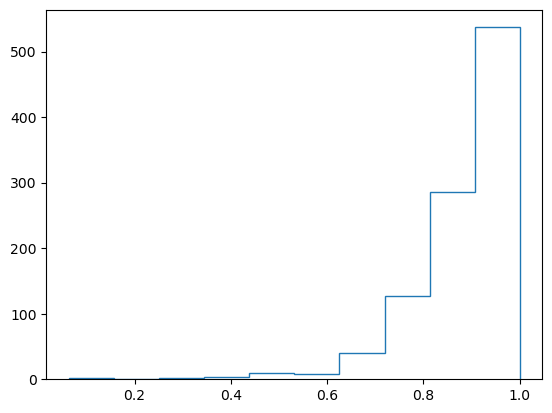

In [94]:
#Select Only the Frames with low RMSD from native state for the native distances
# recompute Q based off of native frames 
Q=1/(1+np.exp(10*(Traj_CA_Distances[:,native_frames]-(Native_Contact_Distances_nframes+1)[:,native_frames])))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,1000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show

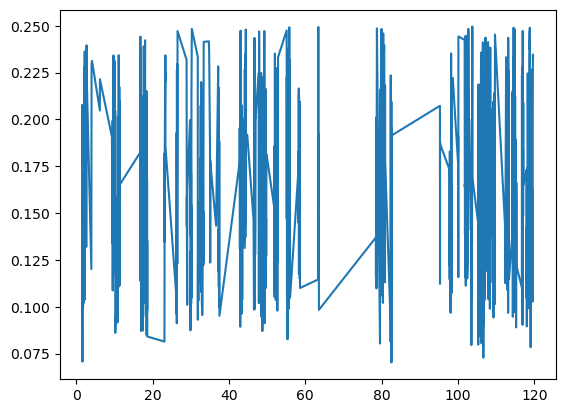

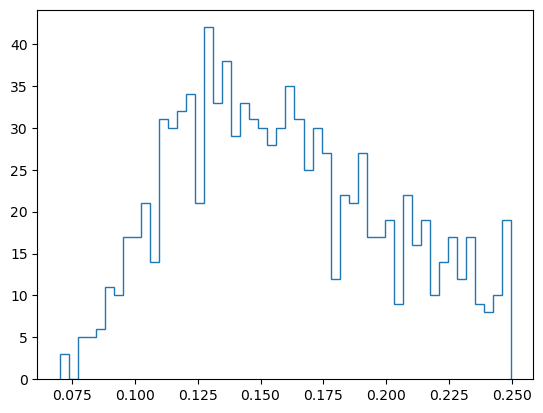

In [95]:
#Select Only the Frames with low RMSD from native state for the native distances
rmsd = md.rmsd(trjCA.slice(native_frames),xray_CA)
plt.plot(time[native_frames],rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

In [96]:
#Filter the native distances to only include distances where the average value < 10A in the native frames 
averages=np.average(Native_Contact_Distances_nframes,axis=1)
Native_Dist_10a=np.where(averages<10.0)[0]
Native_Dist_10a


array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43])

In [ ]:
#Check that we're comparing all the correct distances 


In [ ]:
#Plot Q using only our native frames


In [ ]:
#Lets Calculate Our Transition Paths using the Dual Cutoff Approach 

In [141]:
np.shape(q_map)


(1016,)

In [144]:
tro=[]
total_forward = []
for i in range(0,len(q_map)):
    if q_map[i]<0.1:
        tro = 0
    if q_map[i]>0.9:
        tro = 1
    total_forward.append(tro)
    
total_reverse = []
reverse = []
for i in range(1,len(q_map)+1):
    if q_map[len(q_map)-i]<0.1:
        tro = 0
    if q_map[len(q_map)-i]>0.9:
        tro = 1
    reverse.append(tro)
total_reverse = np.flip(reverse)


In [148]:
total_forward = [item for item in total_forward if isinstance(item, (int, float))]

# Ensure total_forward and total_reverse are lists or NumPy arrays
total_forward = list(total_forward)

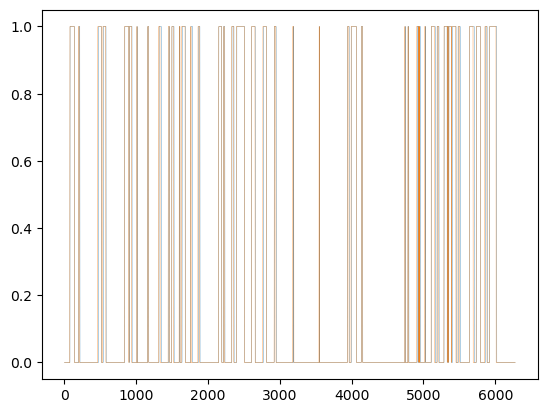

In [150]:
plt.plot(total_forward,linewidth=0.25)
plt.plot(total_reverse,linewidth=0.25)

In [155]:
# Ensure both lists are the same length by truncating or padding
max_length = max(len(total_forward), len(total_reverse))

# Truncate longer list
total_forward = total_forward[:max_length]
total_reverse = total_reverse[:max_length]

# Pad shorter list with zeros
if len(total_forward) < max_length:
    total_forward.extend([0] * (max_length - len(total_forward)))
if len(total_reverse) < max_length:
    total_reverse.extend([0] * (max_length - len(total_reverse)))

trans = []
for i in range(max_length):
    if total_forward[i] != total_reverse[i]:
        trans.append(i)

folded = []
for i in range(0,len(q_map)):
    if total_forward[i]==1:
        if total_forward[i]==total_reverse[i]:
            folded.append(i)    

unfolded = []
for i in range(0,len(q_map)):
    if total_forward[i]==0:
        if total_forward[i]==total_reverse[i]:
            unfolded.append(i)    

# Print the length of both lists for debugging
print("Length of total_forward:", len(total_forward))
print("Length of total_reverse:", len(total_reverse))
print("Length of trans:", len(trans))
print("Length of folded:", len(folded))
print("Length of unfolded:", len(unfolded))

print(len(unfolded)+len(folded)+len(trans))
print(len(q_map))

Length of total_forward: 6280
Length of total_reverse: 6280
Length of trans: 390
Length of folded: 1229
Length of unfolded: 4661
6280
6280


In [156]:
print(trans[590:660])

[]


In [ ]:
#Consider using a windowing function to smooth our values of Q for Transition Path Calculations


The only required task is using the dual-cutoff approach (describe in the SI of "How Fast Folding Proteins Fold". To calculate the locations of transition paths in the trajectory & compute something about transition states (helical content, distance between key native contacts) and demonstrate how it compares to the unfolded state.
If you're going for the HP/A:  Pose a mechanistic/temporal question about transition paths (does this happen before this, etc.) or plot some Transition paths and a free energy surface of your choosing.   Maybe plot some long vs. short TPs?

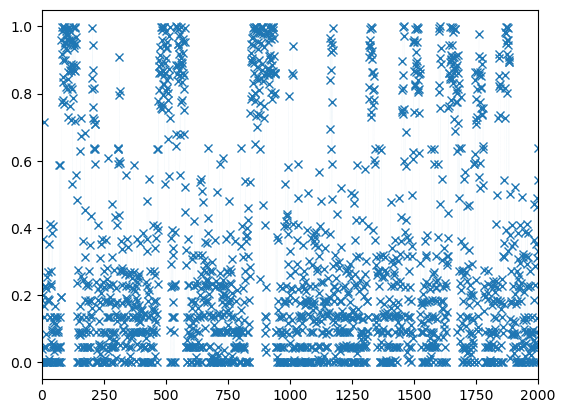

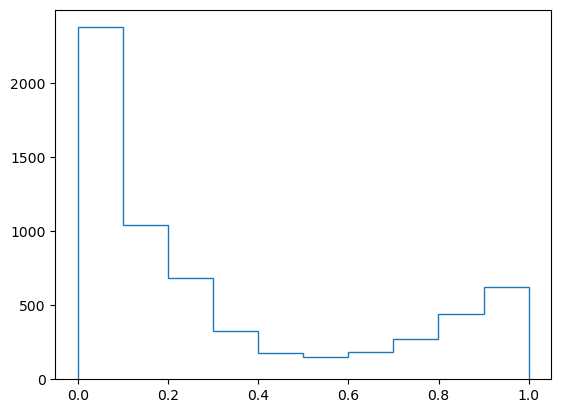

In [98]:
Q=1/(1+np.exp(10*(Traj_CA_Distances-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

In [99]:
# find when Q > 0.90

# Q greater than 0.90
folded_forward = np.where(Q > 0.90)[0]
unfolded_forward = np.where(Q < 0.10)[0]

print(len(folded_forward), len(unfolded_forward))


625 2380


In [101]:
traj_rev = Traj_CA_Distances[::-1]
Q_rev=1/(1+np.exp(10*(traj_rev-(Native_Contact_Distances_nframes+1))))
folded_reverse = np.where(Q_rev > 0.90)[0]
unfolded_reverse = np.where(Q_rev < 0.10)[0]

print(len(folded_forward), len(unfolded_forward))
Native_Contact_Distances_nframes.shape


625 2380


(44, 6280)

In [102]:
time = np.linspace(0, 6279, 6280)  # time points

# Define cutoff thresholds
folded_threshold = 0.9
unfolded_threshold = 0.1
# Step 3: Identify transitions dynamically
transitions = []
in_transition = False
start_time = None
for i in range(1, len(Q)):
    if Q[i-1] > folded_threshold and Q[i] < unfolded_threshold:
        if not in_transition:
            start_time = time[i-1]
            in_transition = True
    elif in_transition and Q[i] < unfolded_threshold:
        end_time = time[i]
        transitions.append((start_time, end_time))
        in_transition = False


In [103]:
transitions

[(1609.0, 1613.0),
 (3194.0, 3196.0),
 (4927.0, 4943.0),
 (5330.0, 5353.0),
 (5883.0, 5886.0)]

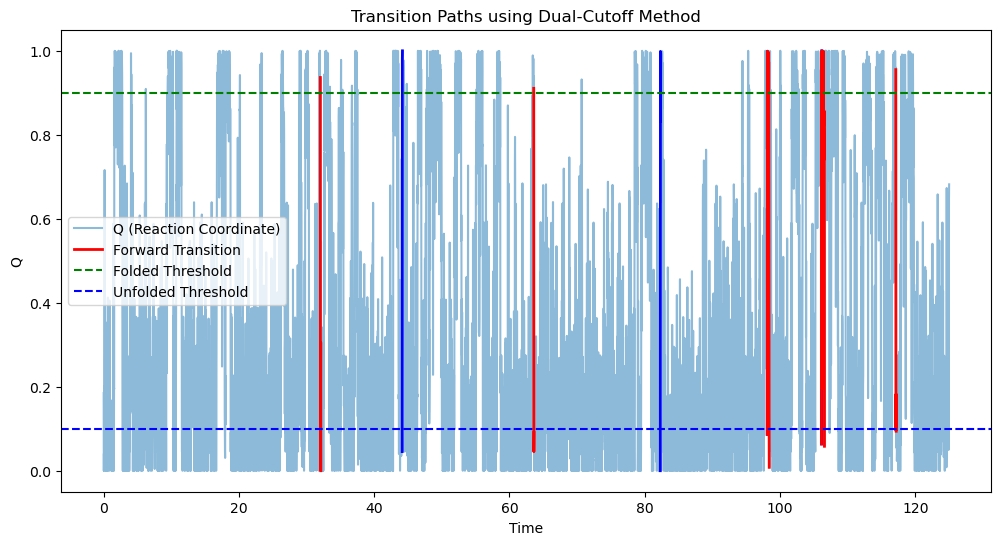

In [128]:
# Define cutoff thresholds
folded_threshold = 0.9
unfolded_threshold = 0.1
# Step 3: Identify transitions dynamically
transitions = []
in_forward_transition = False
in_reverse_transition = False
start_time = None
for i in range(1, len(Q)):
    # Forward transition: Q > 0.9 to Q < 0.1
    if not in_forward_transition and Q[i-1] > folded_threshold and Q[i] < unfolded_threshold:
        start_time = time[i-1]
        in_forward_transition = True
    elif in_forward_transition and Q[i] < unfolded_threshold:
        end_time = time[i]
        transitions.append((start_time, end_time, 'forward'))
        in_forward_transition = False
    # Reverse transition: Q < 0.1 to Q > 0.9
    if not in_reverse_transition and Q[i-1] < unfolded_threshold and Q[i] > folded_threshold:
        start_time = time[i-1]
        in_reverse_transition = True
    elif in_reverse_transition and Q[i] > folded_threshold:
        end_time = time[i]
        transitions.append((start_time, end_time, 'reverse'))
        in_reverse_transition = False
# Step 4: Plot the transition paths
plt.figure(figsize=(12, 6))
plt.plot(time, Q, label='Q (Reaction Coordinate)', alpha=0.5)
# Highlight transition paths
for start, end, direction in transitions:
    # Find indices corresponding to the transition times
    transition_indices = (time >= start) & (time <= end)
    # Plot the transition path
    if direction == 'forward':
        plt.plot(time[transition_indices], Q[transition_indices], color='r', linewidth=2, label='Forward Transition' if start == transitions[0][0] else "")
    elif direction == 'reverse':
        plt.plot(time[transition_indices], Q[transition_indices], color='b', linewidth=2, label='Reverse Transition' if start == transitions[0][0] else "")
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='g', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time')
plt.ylabel('Q')
plt.legend()
plt.title('Transition Paths using Dual-Cutoff Method')
plt.show()

In [129]:
transitions

[(32.031374422678766, 32.11100493709189, 'forward'),
 (44.13521261347348, 44.17502787068004, 'reverse'),
 (63.5849657588788, 63.62478101608536, 'forward'),
 (82.29813664596273, 82.35785953177258, 'reverse'),
 (98.10479375696767, 98.14460901417422, 'reverse'),
 (98.10479375696767, 98.40340818601688, 'forward'),
 (106.12756808408982, 106.16738334129639, 'reverse'),
 (106.12756808408982, 106.565535913362, 'forward'),
 (117.11657907310081, 117.17630195891064, 'forward')]

# Outline for dual-cutoff approach 
## Directions from the paper
1. smoothing by applying a running average filter with a time window of 10 ns
2. defined a subset of the folded state to be those structures that had a value of Q larger than  0.90
3. defined a subset of the unfolded state to be those structures that had a Q smaller than 0.10.

1. Recorded folding and unfolding transitions only when the system transitioned fully between these two substates, thereby removing a number of spurious transitions that would otherwise have been observed using only a single cutoff. 
2. In order to define transition paths, we applied the above analysis in both the forward and reverse time directions. 
3. Frames that were assigned to one state (e.g., unfolded) in the forward direction and a different state (e.g., folded) in the reverse direction were defined to belong to the transition path connecting the two states. 
4. We calculated the folding and unfolding times as the average lifetime in the unfolded and folded states, respectively.

### 1. smoothing by applying a running average filter with a time window of 10 ns

[0.18181703 0.16803258 0.19074422 ... 0.48595176 0.49994177 0.50448705]


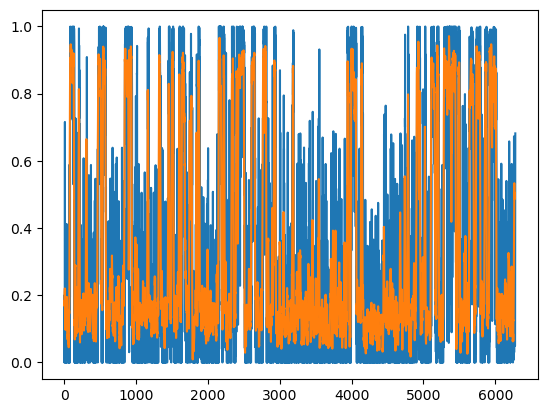

In [130]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Example usage
window_size = 10
smoothed_data = moving_average(Q, window_size)

plt.plot(Q)
plt.plot(smoothed_data)
print(smoothed_data)

### 2. defined a subset of the folded state to be those structures that had a value of Q larger than 0.90

### 3. defined a subset of the unfolded state to be those structures that had a Q smaller than 0.10.

In [131]:
Q_add_m1s = np.where(smoothed_data < 0.10, -1, smoothed_data)
Q_add_1s = np.where(Q_add_m1s > 0.90, 1, Q_add_m1s)
Q_add_0s = np.where(((Q_add_1s < 1) & (Q_add_1s > -1)), 0,  Q_add_1s)

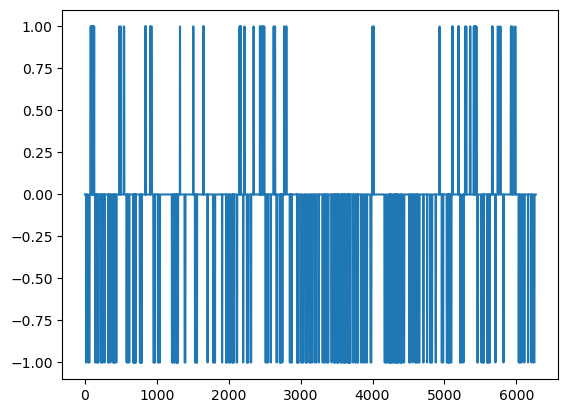

In [132]:
plt.plot(Q_add_0s)


### 4. Recorded folding and unfolding transitions only when the system transitioned fully between these two substates, thereby removing a number of spurious transitions that would otherwise have been observed using only a single cutoff.

In [133]:
upper = False 
lower = False 
transition_fwd = []

for i, q in enumerate(Q_add_0s): 
    if q == 0 and upper and lower: 
        transition_fwd.append(i)
        upper = False 
        lower = False 
    
    elif (q == 0) and (len(transition_fwd) > 0):
        if transition_fwd[-1] + 1 == i: 
            transition_fwd.append(i)     

    elif q == 1: 
        upper = True 
    
    elif q == -1: 
        lower = True

In [134]:
upper = False 
lower = False 
transition_rev = []

for i, q in enumerate(Q_add_0s[::-1]): 
    if q == 0 and upper and lower: 
        transition_rev.append(i)
        upper = False 
        lower = False 
    
    elif (q == 0) and (len(transition_rev) > 0):
        if transition_rev[-1] + 1 == i: 
            transition_rev.append(i)     

    elif q == 1: 
        upper = True 
    
    elif q == -1: 
        lower = True

### 5. In order to define transition paths, we applied the above analysis in both the forward and reverse time directions.

In [135]:
transition_rev_ = np.arange(len(Q_add_0s))[::-1][transition_rev]
transition_paths = np.intersect1d(transition_fwd, transition_rev_)

(0.0, 6500.0)

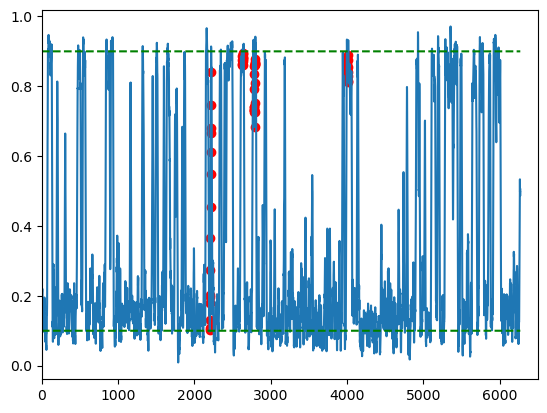

In [139]:
plt.plot(np.arange(len(smoothed_data)), smoothed_data)
plt.scatter(np.arange(len(smoothed_data))[transition_paths], smoothed_data[transition_paths], color="red")
plt.plot(np.arange(len(smoothed_data)), [0.9]*len(smoothed_data), linestyle="--" ,color="green" )
plt.plot(np.arange(len(smoothed_data)), [0.1]*len(smoothed_data), linestyle="--" ,color="green" )

plt.xlim(0, 6500)

(2000.0, 3000.0)

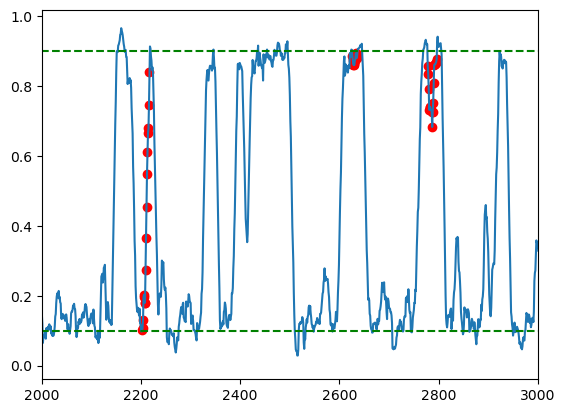

In [140]:
plt.plot(np.arange(len(smoothed_data)), smoothed_data)
plt.scatter(np.arange(len(smoothed_data))[transition_paths], smoothed_data[transition_paths], color="red")
plt.plot(np.arange(len(smoothed_data)), [0.9]*len(smoothed_data), linestyle="--" ,color="green" )
plt.plot(np.arange(len(smoothed_data)), [0.1]*len(smoothed_data), linestyle="--" ,color="green" )

plt.xlim(2000, 3000)

### 6. Frames that were assigned to one state (e.g., unfolded) in the forward direction and a different state (e.g., folded) in the reverse direction were defined to belong to the transition path connecting the two states.

In [157]:
# Ensure both lists are the same length by truncating or padding
max_length = max(len(total_forward), len(total_reverse))

# Truncate longer list
total_forward = total_forward[:max_length]
total_reverse = total_reverse[:max_length]

# Pad shorter list with zeros
if len(total_forward) < max_length:
    total_forward.extend([0] * (max_length - len(total_forward)))
if len(total_reverse) < max_length:
    total_reverse.extend([0] * (max_length - len(total_reverse)))

# Initialize lists for classification
trans = []
folded = []
unfolded = []

# Classify frames
for i in range(max_length):
    if total_forward[i] != total_reverse[i]:
        trans.append(i)
    else:
        if total_forward[i] == 1:
            folded.append(i)
        elif total_forward[i] == 0:
            unfolded.append(i)

# Print the lengths of the lists for debugging
print("Length of total_forward:", len(total_forward))
print("Length of total_reverse:", len(total_reverse))
print("Length of trans:", len(trans))
print("Length of folded:", len(folded))
print("Length of unfolded:", len(unfolded))

Length of total_forward: 6280
Length of total_reverse: 6280
Length of trans: 390
Length of folded: 1229
Length of unfolded: 4661


In [160]:
print(trans)

[77, 138, 139, 140, 194, 195, 196, 197, 198, 199, 200, 201, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 536, 537, 538, 539, 540, 578, 579, 837, 838, 839, 840, 896, 897, 898, 903, 904, 937, 938, 939, 940, 941, 1009, 1010, 1160, 1174, 1313, 1314, 1315, 1316, 1317, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1463, 1496, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1598, 1599, 1609, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1681, 1682, 1683, 1684, 1685, 1686, 1760, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 2189, 2190, 2191, 2217, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2329, 2330, 2331, 2332, 2359, 2360, 2361, 2394, 239

In [162]:
transtime_indices = [904, 937, 938, 939, 940, 941, 1009, 1010, 1160, 1174, 1313, 1314, 1315, 1316, 1317, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1463, 1496, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1598, 1599, 1609, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1681, 1682, 1683, 1684, 1685, 1686, 1760, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 2189, 2190, 2191, 2217, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2329, 2330, 2331, 2332, 2359, 2360, 2361, 2394, 2395, 2396, 2397, 2398, 2399, 2400]

trans_times = tuple(time[i] for i in transtime_indices)

In [165]:
q_map = []
for i in range(0, 6280):
    qinit=qCalc(Native_Contacts_Trj_Dist[:,i],Native_Contacts_Xray_Dist)
    q_map.append(qinit)
np.shape(q_map)

/var/folders/vz/4nf96m054hbgp3bpn87yln540000gn/T/ipykernel_8899/1295253252.py:3: RuntimeWarning: overflow encountered in exp
  num=np.sum(1/(1+np.exp(10*np.subtract(dist,nativedist+1))))


(6280,)

In [166]:
q_map[904:2400]

[0.2162653052288553,
 0.10526157462078592,
 0.9788003175154977,
 0.9419975280761719,
 0.8510231349779211,
 0.9418710625689962,
 0.8377991551938264,
 0.9566318677819293,
 0.9988107266633407,
 0.8765918068263842,
 0.9677867060122283,
 0.837549873020338,
 0.8608006187107252,
 0.8732692884362262,
 0.9078141917353091,
 0.8241295192552649,
 0.9182909260625425,
 0.8705040475596553,
 0.9643629322881284,
 0.7691634634266729,
 0.9655335467794667,
 0.8649766341499661,
 0.9962466696034307,
 0.9967348679252293,
 0.8482185032056726,
 0.9542987657629926,
 0.7933850495711617,
 0.9988017704175867,
 0.8734632574993632,
 0.9720934992251189,
 0.9906102056088655,
 0.9129364179528278,
 0.9671090167501698,
 0.825100442637568,
 0.765554842741593,
 0.8242097108260446,
 0.8252799821936566,
 0.8643906634786854,
 0.7666929493779722,
 0.08638998736505923,
 0.08745353118233058,
 0.08695602416992188,
 0.044498018596483314,
 0.35690199810525647,
 0.01590351954750393,
 4.433674272964436e-18,
 0.04386355047640593,
 0.3

### 7. We calculated the folding and unfolding times as the average lifetime in the unfolded and folded states, respectively.

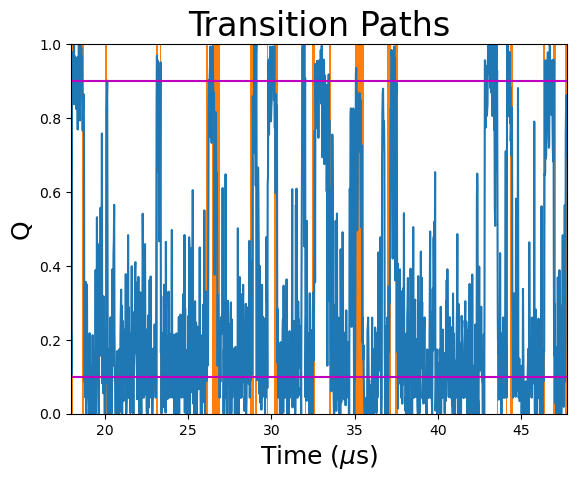

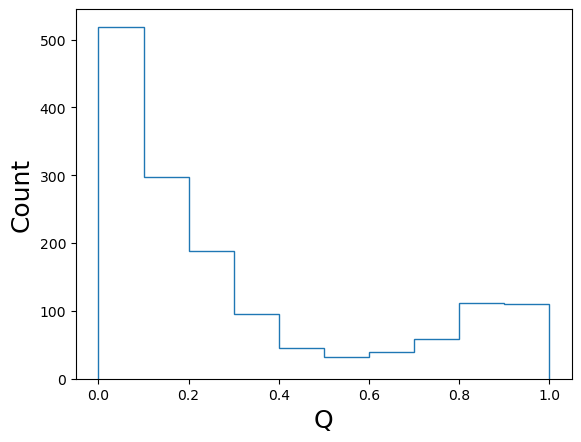

In [168]:
plt.plot(time[904:2400],q_map[904:2400])
plt.hist(trans_times,bins=380)
plt.plot([time[904],time[2400]],[0.9,0.9],"m")
plt.plot([time[904],time[2400]],[0.1,0.1],"m")
plt.xlabel("Time ($\mu$s)",size=18)
plt.ylabel("Q",size=18)
plt.xlim([time[904],time[2400]])
plt.ylim([0,1])
plt.title("Transition Paths",size=24)
plt.show()
plt.hist(q_map[904:2400],bins=10,range=[0,1],histtype='step')
plt.xlabel("Q",size=18)
plt.ylabel("Count",size=18)
plt.show()

In [ ]:
# Pose a mechanistic/temporal question about transition paths (does this happen before this, etc.) or 
# plot some Transition paths and a free energy surface of your choosing.   
# Maybe plot some long vs. short TPs

In [170]:
trjfold=trj[folded]
trjunfold=trj[unfolded]
trjtransition=trj[trans]

indices_phi_unfolded, phis_unfolded = md.compute_phi(trjunfold)
indices_psi_unfolded, psis_unfolded = md.compute_psi(trjunfold)
indices_phi_folded, phis_folded = md.compute_phi(trjfold)
indices_psi_folded, psis_folded = md.compute_psi(trjfold)
indices_phi_trans, phis_trans = md.compute_phi(trjtransition)
indices_psi_trans, psis_trans = md.compute_psi(trjtransition)

SS: H [ 5 21 22 23 24]
SS: E []
SS: I []
SS: G []
SS: B []
SS: T []
SS: S []


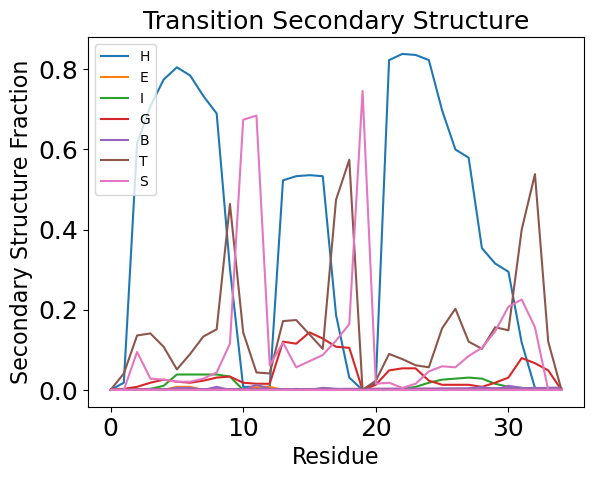

In [171]:
dssp_full_trans=md.compute_dssp(trjtransition,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S']:
  Tprop=dssp_convert_type(dssp_full_trans,t)
  plt.plot(np.subtract(residue_num,42),Tprop,label=t)
  print("SS:",t,np.asarray(np.subtract(residue_num,42))[np.where(Tprop>.80)])

plt.legend(loc="upper left")
plt.title("Transition Secondary Structure", size=18)
plt.xlabel('Residue', size=16)
plt.ylabel('Secondary Structure Fraction', size=16)
plt.tick_params(labelsize=18)

Transition Path Frames: [   0    1    2 ... 6277 6278 6279]
Average Helical Content (Transition): 0.17863284804367607
Average Helical Content (Unfolded): 0.1357142857142857
Average Distance (Transition): 0.6461067795753479
Average Distance (Unfolded): 0.6194006204605103


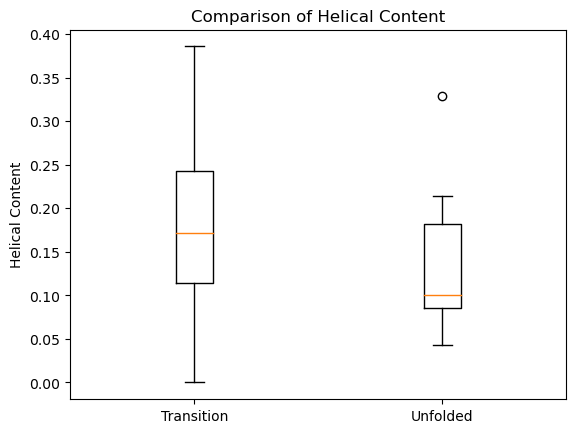

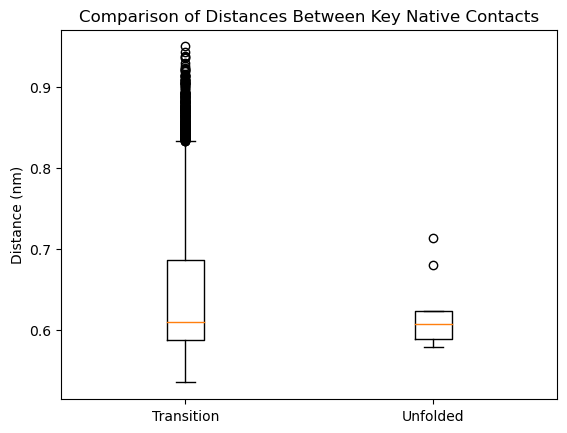

In [92]:
# calculate the locations of transition paths in the trajectory &; 
# compute something about transition states (helical content, distance between key native contacts) 
# demonstrate how it compares to the unfolded state.

# Define native contacts (e.g., between residues i and j)
native_contacts = [(i, j) for i in range(10, 20) for j in range(30, 40)]

# Define cutoffs for dual-cutoff approach (in nanometers)
cutoff_inner = 0.45  # Inner cutoff for defining contacts
cutoff_outer = 0.65  # Outer cutoff for transition path identification

# Function to calculate contacts
def calculate_contacts(traj, contacts, cutoff):
    distances = md.compute_distances(traj, contacts)
    contact_map = distances < cutoff
    return contact_map

# Calculate contacts using inner and outer cutoffs
contacts_inner = calculate_contacts(trj, native_contacts, cutoff_inner)
contacts_outer = calculate_contacts(trj, native_contacts, cutoff_outer)

# Identify transition path frames
transition_frames = np.where(np.any(contacts_outer & ~contacts_inner, axis=1))[0]

# Print transition path frames for verification
print(f"Transition Path Frames: {transition_frames}")

# Function to calculate helical content
def calculate_helical_content(traj):
    dssp = md.compute_dssp(traj)
    helical_content = np.mean(dssp == 'H', axis=1)
    return helical_content

# Calculate helical content for transition states
helical_content_transition = calculate_helical_content(trj[transition_frames])

# Define unfolded state frames (e.g., initial or high-temperature frames)
unfolded_frames = range(0, 10)  # Adjust as needed

# Calculate helical content for unfolded states
helical_content_unfolded = calculate_helical_content(trj[unfolded_frames])

# Calculate distance between key native contacts for transition states
distances_transition = md.compute_distances(trj[transition_frames], native_contacts)

# Calculate distance between key native contacts for unfolded states
distances_unfolded = md.compute_distances(trj[unfolded_frames], native_contacts)

# Compare helical content and distances
print(f"Average Helical Content (Transition): {np.mean(helical_content_transition)}")
print(f"Average Helical Content (Unfolded): {np.mean(helical_content_unfolded)}")
print(f"Average Distance (Transition): {np.mean(distances_transition)}")
print(f"Average Distance (Unfolded): {np.mean(distances_unfolded)}")

# Visualize the comparison
import matplotlib.pyplot as plt

# Helical Content
plt.figure()
plt.boxplot([helical_content_transition, helical_content_unfolded], labels=['Transition', 'Unfolded'])
plt.ylabel('Helical Content')
plt.title('Comparison of Helical Content')

# Distances
plt.figure()
plt.boxplot([np.mean(distances_transition, axis=1), np.mean(distances_unfolded, axis=1)], labels=['Transition', 'Unfolded'])
plt.ylabel('Distance (nm)')
plt.title('Comparison of Distances Between Key Native Contacts')

plt.show()

